In [ ]:
#Took out sensitive connection parameters for security reasons
import psycopg2
import pandas as pd

conn_params = {
    "host": "MY_HOST",
    "port": "5439",
    "dbname": "dev",
    "user": "MY_USER",
    "password": "MY_PASSWORD"
}

In [ ]:
def fetch_redshift(query, conn_params):
    conn = psycopg2.connect(**conn_params)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

In [8]:
stats_query = """
SET search_path TO nba;

SELECT 
    f.player_key,
    f.season_key,
    p.full_name AS Player,
    f.team_key,
    t.team_name AS Team,
    f.pos as Position,
    s.start_year AS Year,
    f.age AS Age,
    f.perce AS PER,
    f.ts_per AS TS_pct,
    f.usg_per AS USG_pct,
    f.ws AS WS,
    f.bpm AS BPM,
    f.vorp AS VORP,
    f.mp AS MP,
    f.salary AS Salary
FROM fact_player_season f
JOIN dim_player p ON f.player_key = p.player_key
JOIN dim_team t ON f.team_key = t.team_key
JOIN dim_season s ON f.season_key = s.season_key
"""

In [9]:
stats = fetch_redshift(stats_query, conn_params)
print(stats.head())

C:\Users\werdn\AppData\Local\Temp\ipykernel_22588\1818394797.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


  player_key  season_key          player team_key                    team  \
0  randlju01        2021   Julius Randle      NYK         New York Knicks   
1  barrerj01        2021      RJ Barrett      NYK         New York Knicks   
2  jokicni01        2021    Nikola Jokic      DEN          Denver Nuggets   
3  hieldbu01        2021     Buddy Hield      SAC        Sacramento Kings   
4  lillada01        2021  Damian Lillard      POR  Portland Trail Blazers   

  position  year  age   per  ts_pct  usg_pct    ws   bpm  vorp    mp  \
0       PF  2020   26  19.7   0.567     29.3   7.8   3.8   3.9  2667   
1       SG  2020   20  13.4   0.535     23.4   4.1  -1.2   0.5  2511   
2        C  2020   25  31.3   0.647     29.6  15.6  12.1   8.8  2488   
3       SG  2020   28  12.8   0.567     20.7   2.2  -0.6   0.9  2433   
4       PG  2020   30  25.6   0.623     31.4  10.4   6.3   5.0  2398   

       salary  
0  24184931.0  
1  10031975.0  
2  36002595.0  
3  30384192.0  
4  38543497.0  


In [ ]:
export_csv = pd.read_csv("fact_player_season.csv")

merged_df = export_csv.merge(
         stats, 
         on=["player_key", "season_key"],
         how="left",
         suffixes=('', '_rs')
         )

print(merged_df.head())

  player_key team_key  season_key pos   g  gs  perce  ts_per  usg_per    ws  \
0  randlju01      NYK        2021  PF  71  71   19.7   0.567     29.3   7.8   
1  barrerj01      NYK        2021  SG  72  72   13.4   0.535     23.4   4.1   
2  jokicni01      DEN        2021   C  72  72   31.3   0.647     29.6  15.6   
3  hieldbu01      SAC        2021  SG  71  71   12.8   0.567     20.7   2.2   
4  lillada01      POR        2021  PG  67  67   25.6   0.623     31.4  10.4   

   ...    year  age_rs   per  ts_pct  usg_pct ws_rs bpm_rs vorp_rs   mp_rs  \
0  ...  2020.0    26.0  19.7   0.567     29.3   7.8    3.8     3.9  2667.0   
1  ...  2020.0    20.0  13.4   0.535     23.4   4.1   -1.2     0.5  2511.0   
2  ...  2020.0    25.0  31.3   0.647     29.6  15.6   12.1     8.8  2488.0   
3  ...  2020.0    28.0  12.8   0.567     20.7   2.2   -0.6     0.9  2433.0   
4  ...  2020.0    30.0  25.6   0.623     31.4  10.4    6.3     5.0  2398.0   

    salary_rs  
0  24184931.0  
1  10031975.0  
2  36002

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

metrics = ["perce", "ts_per", "usg_per", "ws", "bpm", "vorp", "mp"]
merged_df_filtered = merged_df[merged_df["mp"] >= 750].copy()

df_reg = merged_df_filtered.dropna(subset=metrics + ["salary"])

X = df_reg[metrics].values
y = df_reg["salary"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LinearRegression()
model.fit(X_scaled, y)

print("Intercept:", model.intercept_)
coef_series = pd.Series(model.coef_, index=metrics)
print("Coefficients:")
print(coef_series)

Intercept: 14203601.628884027
Coefficients:
perce     -2.045865e+06
ts_per    -4.502868e+05
usg_per    5.228901e+06
ws         4.128245e+05
bpm        5.979101e+06
vorp      -1.567423e+05
mp         9.151484e+05
dtype: float64


In [ ]:
mask = merged_df[metrics].notnull().all(axis=1)

def predicted_salary(row):
    X_player = row[metrics].values.reshape(1, -1)
    X_player_scaled = scaler.transform(X_player)
    return model.predict(X_player_scaled)[0]

merged_df.loc[mask, "deserved_salary"] = merged_df.loc[mask].apply(predicted_salary, axis=1).round(2)
merged_df.loc[mask, "salary_gap"] = merged_df.loc[mask, "deserved_salary"] - merged_df.loc[mask, "salary"].round(2)
merged_df.loc[mask, "overpaid_underpaid"] = merged_df.loc[mask, "salary"] - merged_df.loc[mask, "deserved_salary"].round(2)
merged_df.loc[mask, "value"] = np.dot(scaler.transform(merged_df.loc[mask, metrics]), model.coef_).round(2)

threshold = 0.15

merged_df['fair_value'] = merged_df.apply(
    lambda row: True if pd.notnull(row['overpaid_underpaid']) and 
                        -threshold * row['deserved_salary'] <= row['overpaid_underpaid'] <= threshold * row['deserved_salary']
                        else False,
    axis=1
)

print(merged_df.loc[mask, ["player_key", "season_key", "salary", "deserved_salary", "salary_gap", "overpaid_underpaid", "fair_value", "value"]].head())

  player_key  season_key      salary  deserved_salary   salary_gap  \
0  randlju01        2021  24184931.0      32058741.06   7873810.06   
1  barrerj01        2021  10031975.0      18235992.20   8204017.20   
2  jokicni01        2021  36002595.0      44953480.67   8950885.67   
3  hieldbu01        2021  30384192.0      16499819.84 -13884372.16   
4  lillada01        2021  38543497.0      36132487.11  -2411009.89   

   overpaid_underpaid  fair_value        value  
0         -7873810.06       False  17855139.43  
1         -8204017.20       False   4032390.57  
2         -8950885.67       False  30749879.04  
3         13884372.16       False   2296218.21  
4          2411009.89        True  21928885.48  


C:\Users\werdn\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
cols_order = ["player_key","team_key","season_key","pos","g","gs","perce","ts_per","usg_per","ws","bpm", "vorp",
"mp","age","salary","value","deserved_salary","salary_gap","overpaid_underpaid", "fair_value"]

new_df = merged_df.drop_duplicates(subset=["player_key", "team_key", "season_key"], keep="first")

new_df.to_csv("player_metrics_updated.csv", index=False, columns=cols_order, float_format="%.2f")
print("Updated CSV exported")

Updated CSV exported!


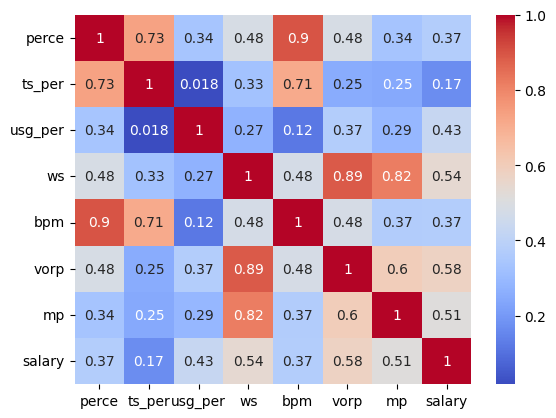

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(merged_df[metrics + ['salary']].corr(), annot=True, cmap='coolwarm')
plt.show()

#### **Predicted Salary = 13324891.786852593 - (1.554644e+06 * PER_scaled) - (6.000731e+05 * TS_pct_scaled) + (4.947034e+06 * USG_pct_scaled) + (1.759275e+06 * WS_scaled) + (4.254064e+06 * BPM_scaled) + (2.498902e+05 * VORP_scaled) + (1.280713e+06 * MP_scaled)**

In [ ]:
import boto3

#Files fact_player_season_final.csv and player_metrics_updated.csv are the same bc this code puts csv into s3
#Have player_metrics_updated.csv in same directory
aws_access_key_id = "MY_AWS_ACCESS_KEY"
aws_secret_access_key = "MY_AWS_SECRET_KEY"
region = "us-west-1"
bucket_name = "data226finalproject"
file_path = "player_metrics_updated.csv"
s3_key = "fact_player_season_final.csv"

s3 = boto3.client(
    "s3",
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name=region
)

try:
    s3.upload_file(file_path, bucket_name, s3_key)
    print(f"Successfully uploaded to s3")
except Exception as e:
    print("Upload failed:", e)

✅ Successfully uploaded


In [ ]:
conn = psycopg2.connect(**conn_params)
cur = conn.cursor()

cur.execute("SET search_path TO nba;")
conn.commit()
cur.execute("DROP TABLE IF EXISTS fact_player_season;")
executing = f"""
CREATE TABLE IF NOT EXISTS fact_player_season (
  player_key VARCHAR(15) REFERENCES dim_player(player_key),
  team_key VARCHAR(3) REFERENCES dim_team(team_key),
  season_key INT REFERENCES dim_season(season_key),
  pos VARCHAR(5),
  g INT,
  gs INT,
  perce DECIMAL(7,2),
  ts_per DECIMAL(7,3),
  usg_per DECIMAL(7,2),
  ws DECIMAL(7,2),
  bpm DECIMAL(7,2),
  vorp DECIMAL(7,2),
  mp INT,
  age INT,
  salary DECIMAL(12,2),
  value DECIMAL(18,6),
  deserved_salary DECIMAL(18,2),
  salary_gap DECIMAL(18,2),
  overpaid_underpaid DECIMAL(18,2),
  fair_value BOOLEAN,
  PRIMARY KEY (player_key, team_key, season_key)
); 
"""
cur.execute(executing)
conn.commit()

copy_sql = f"""
COPY fact_player_season
FROM 's3://data226finalproject/fact_player_season_final.csv'
IAM_ROLE 'MY_IAM_ROLE'
REGION 'us-west-1'
FORMAT AS CSV
IGNOREHEADER 1
DELIMITER ','
EMPTYASNULL
BLANKSASNULL
TRUNCATECOLUMNS;
"""

cur.execute(copy_sql)
conn.commit()
cur.close()
conn.close()